# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.12.0-sigma.new.339.357.359.362.366.367.382.383.fix.360.373'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Please set verbose=2 to see the detailed citation list.




Retrieving linelist from Open COVID-19 Data Working Group repository: https://github.com/beoutbreakprepared/nCoV2019


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


### Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

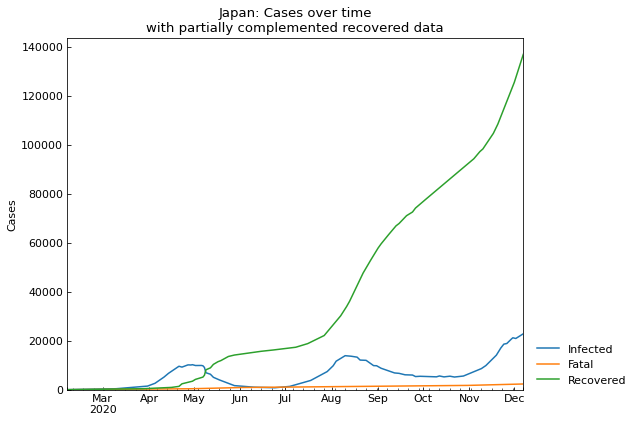

,Date,Confirmed,Infected,Fatal,Recovered
301,2020-12-03,152827,21373,2213,129241
302,2020-12-04,155232,21816,2240,131176
303,2020-12-05,157674,21948,2283,133443
304,2020-12-06,160098,22506,2315,135277
305,2020-12-07,162067,22829,2335,136903


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of new cases with `Scenario.record_diff()` method.

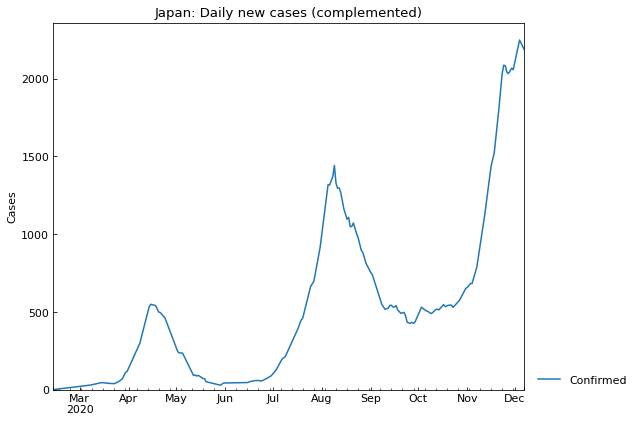

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

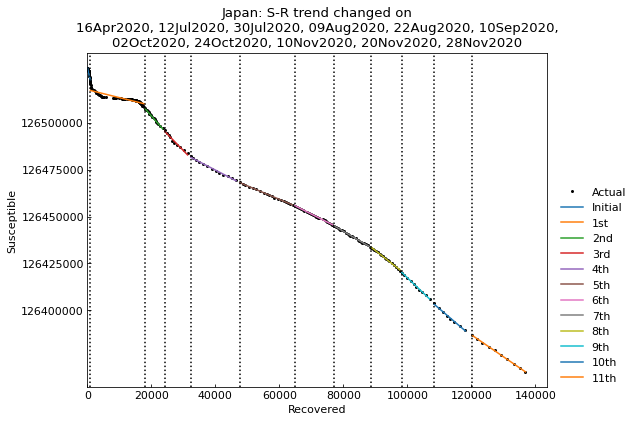

,Type,Start,End,Population
0th,Past,06Feb2020,15Apr2020,126529100
1st,Past,16Apr2020,11Jul2020,126529100
2nd,Past,12Jul2020,29Jul2020,126529100
3rd,Past,30Jul2020,08Aug2020,126529100
4th,Past,09Aug2020,21Aug2020,126529100
5th,Past,22Aug2020,09Sep2020,126529100
6th,Past,10Sep2020,01Oct2020,126529100
7th,Past,02Oct2020,23Oct2020,126529100
8th,Past,24Oct2020,09Nov2020,126529100
9th,Past,10Nov2020,19Nov2020,126529100


In [8]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [9]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 3rd phase (10Sep2020 - 01Oct2020): finished  225 trials in 0 min 10 sec


	 9th phase (02Oct2020 - 23Oct2020): finished 3171 trials in 3 min  0 sec

	 6th phase (30Jul2020 - 08Aug2020): finished 3246 trials in 3 min  0 sec

	 0th phase (06Feb2020 - 15Apr2020): finished 3111 trials in 3 min  0 sec

	11th phase (24Oct2020 - 09Nov2020): finished 3201 trials in 3 min  0 sec

	 2nd phase (10Nov2020 - 19Nov2020): finished  363 trials in 0 min 10 sec

	 1st phase (28Nov2020 - 07Dec2020): finished 1220 trials in 0 min 40 sec

	 4th phase (22Aug2020 - 09Sep2020): finished 1206 trials in 0 min 40 sec

	 7th phase (09Aug2020 - 21Aug2020): finished 3479 trials in 3 min  0 sec

	10th phase (16Apr2020 - 11Jul2020): finished 3311 trials in 3 min  0 sec

	 5th phase (12Jul2020 - 29Jul2020): finished 3420 trials in 3 min  0 sec

	 8th phase (20Nov2020 - 27Nov2020): finished 3388 trials in 3 min  0 sec

Completed optimization. Total: 6 min 52 sec


In [10]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/gamma [day],1/beta [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,06Feb2020,15Apr2020,126529100,SIR-F,4.82,0.018200,0.000063,0.012977,0.002578,180,1981,48,9,0.018,0.255924,3111,3 min 0 sec
1st,Past,16Apr2020,11Jul2020,126529100,SIR-F,0.53,0.017007,0.000366,0.003742,0.006631,180,341,18,33,0.017,0.336706,3311,3 min 0 sec
2nd,Past,12Jul2020,29Jul2020,126529100,SIR-F,1.95,0.000537,0.000022,0.016942,0.008646,180,5580,14,7,0.001,0.018865,3420,3 min 0 sec
3rd,Past,30Jul2020,08Aug2020,126529100,SIR-F,1.84,0.000585,0.000051,0.017536,0.009451,180,2471,13,7,0.001,0.029924,3246,3 min 0 sec
4th,Past,09Aug2020,21Aug2020,126529100,SIR-F,0.94,0.001060,0.000069,0.010270,0.010808,180,1805,11,12,0.001,0.026671,3479,3 min 0 sec
5th,Past,22Aug2020,09Sep2020,126529100,SIR-F,0.73,0.000155,0.000176,0.009291,0.012613,180,711,9,13,0.000,0.021386,1206,0 min 40 sec
6th,Past,10Sep2020,01Oct2020,126529100,SIR-F,0.82,0.003673,0.000146,0.010206,0.012208,180,855,10,12,0.004,0.038529,225,0 min 10 sec
7th,Past,02Oct2020,23Oct2020,126529100,SIR-F,0.99,0.000341,0.000122,0.013557,0.013620,180,1026,9,9,0.000,0.014236,3171,3 min 0 sec
8th,Past,24Oct2020,09Nov2020,126529100,SIR-F,1.27,0.000086,0.000144,0.014478,0.011280,180,866,11,8,0.000,0.019875,3201,3 min 0 sec
9th,Past,10Nov2020,19Nov2020,126529100,SIR-F,1.57,0.000435,0.000098,0.017515,0.011073,180,1274,11,7,0.000,0.013255,363,0 min 10 sec


### Accuracy of estimation

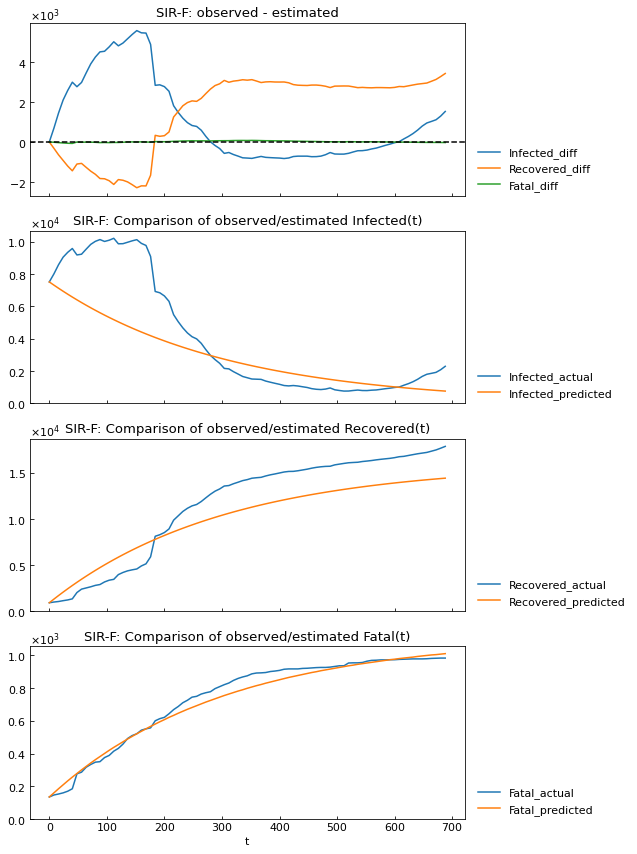

In [11]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [12]:
snl.get("Rt", phase="4th")

0.94

### Show parameter history

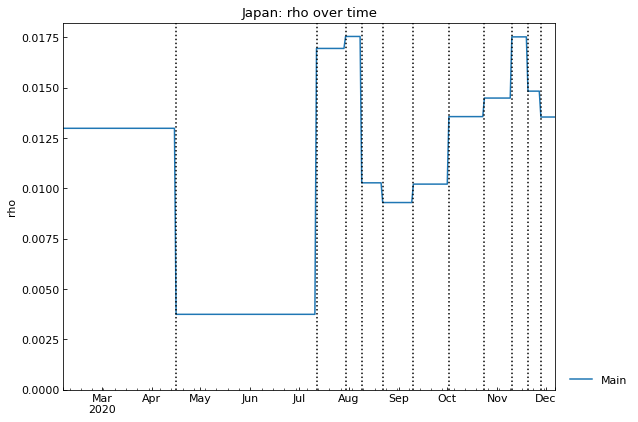

In [13]:
_ = snl.history(target="rho")

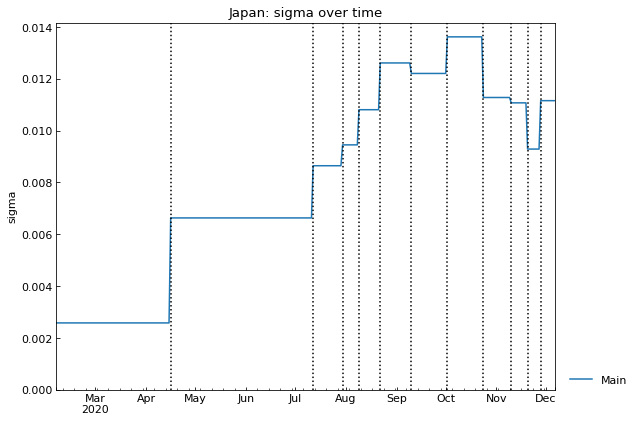

In [14]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

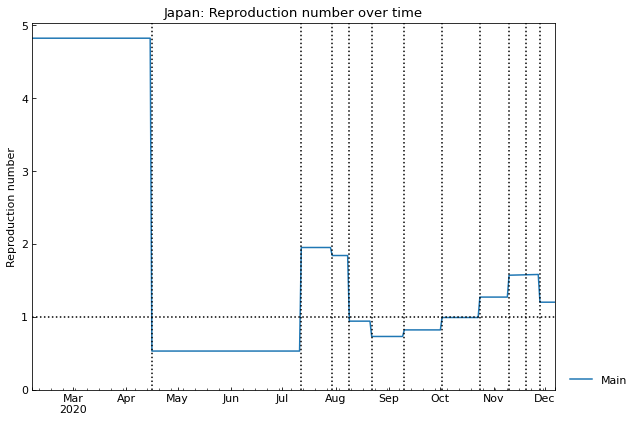

In [15]:
_ = snl.history(target="Rt")

### Simulate the number of cases

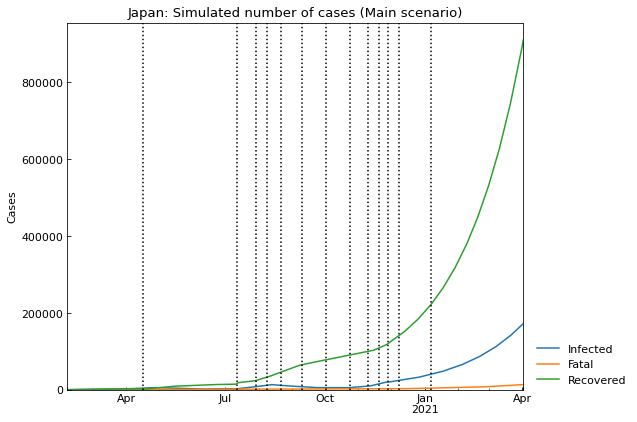

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,1024333,12500,160917,850916
418,2021-03-30,1041764,12706,163656,865402
419,2021-03-31,1059490,12917,166439,880134
420,2021-04-01,1077513,13130,169267,895116
421,2021-04-02,1095840,13348,172140,910352


In [16]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [17]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.01115733209541639

In [18]:
sigma_new = sigma_current * 2
sigma_new

0.02231466419083278

In [19]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  15Apr2020   126529100  SIR-F  4.82   
         1st      Past  16Apr2020  11Jul2020   126529100  SIR-F  0.53   
         2nd      Past  12Jul2020  29Jul2020   126529100  SIR-F  1.95   
         3rd      Past  30Jul2020  08Aug2020   126529100  SIR-F  1.84   
         4th      Past  09Aug2020  21Aug2020   126529100  SIR-F  0.94   
         5th      Past  22Aug2020  09Sep2020   126529100  SIR-F  0.73   
         6th      Past  10Sep2020  01Oct2020   126529100  SIR-F  0.82   
         7th      Past  02Oct2020  23Oct2020   126529100  SIR-F  0.99   
         8th      Past  24Oct2020  09Nov2020   126529100  SIR-F  1.27   
         9th      Past  10Nov2020  19Nov2020   126529100  SIR-F  1.57   
         10th     Past  20Nov2020  27Nov2020   126529100  SIR-F  1.58   
         11th     Past  28Nov2020  07Dec2020   126529100  SIR-F  1.20   
         12th   Future  08Dec2020  06Jan2021   126529100  SIR-F  1.20   
         13th   Future  07Jan2021  01Apr2021   126529100  SIR-F  1.20   
Medicine 0th      Past  06Feb2020  15Apr2020   126529100  SIR-F  4.82   
         1st      Past  16Apr2020  11Jul2020   126529100  SIR-F  0.53   
         2nd      Past  12Jul2020  29Jul2020   126529100  SIR-F  1.95   
         3rd      Past  30Jul2020  08Aug2020   126529100  SIR-F  1.84   
         4th      Past  09Aug2020  21Aug2020   126529100  SIR-F  0.94   
         5th      Past  22Aug2020  09Sep2020   126529100  SIR-F  0.73   
         6th      Past  10Sep2020  01Oct2020   126529100  SIR-F  0.82   
         7th      Past  02Oct2020  23Oct2020   126529100  SIR-F  0.99   
         8th      Past  24Oct2020  09Nov2020   126529100  SIR-F  1.27   
         9th      Past  10Nov2020  19Nov2020   126529100  SIR-F  1.57   
         10th     Past  20Nov2020  27Nov2020   126529100  SIR-F  1.58   
         11th     Past  28Nov2020  07Dec2020   126529100  SIR-F  1.20   
         12th   Future  08Dec2020  06Jan2021   126529100  SIR-F  1.20   
         13th   Future  07Jan2021  01Apr2021   126529100  SIR-F  0.60   

                   theta     kappa       rho     sigma  tau  1/alpha2 [day]  \
Scenario Phase                                                                
Main     0th    0.018200  0.000063  0.012977  0.002578  180            1981   
         1st    0.017007  0.000366  0.003742  0.006631  180             341   
         2nd    0.000537  0.000022  0.016942  0.008646  180            5580   
         3rd    0.000585  0.000051  0.017536  0.009451  180            2471   
         4th    0.001060  0.000069  0.010270  0.010808  180            1805   
         5th    0.000155  0.000176  0.009291  0.012613  180             711   
         6th    0.003673  0.000146  0.010206  0.012208  180             855   
         7th    0.000341  0.000122  0.013557  0.013620  180            1026   
         8th    0.000086  0.000144  0.014478  0.011280  180             866   
         9th    0.000435  0.000098  0.017515  0.011073  180            1274   
         10th   0.000493  0.000097  0.014821  0.009289  180            1288   
         11th   0.001111  0.000144  0.013537  0.011157  180             866   
         12th   0.001111  0.000144  0.013537  0.011157  180             866   
         13th   0.001111  0.000144  0.013537  0.011157  180             866   
Medicine 0th    0.018200  0.000063  0.012977  0.002578  180            1981   
         1st    0.017007  0.000366  0.003742  0.006631  180             341   
         2nd    0.000537  0.000022  0.016942  0.008646  180            5580   
         3rd    0.000585  0.000051  0.017536  0.009451  180            2471   
         4th    0.001060  0.000069  0.010270  0.010808  180            1805   
         5th    0.000155  0.000176  0.009291  0.012613  180             711   
         6th    0.003673  0.000146  0.010206  0.012208  180             855   
         7

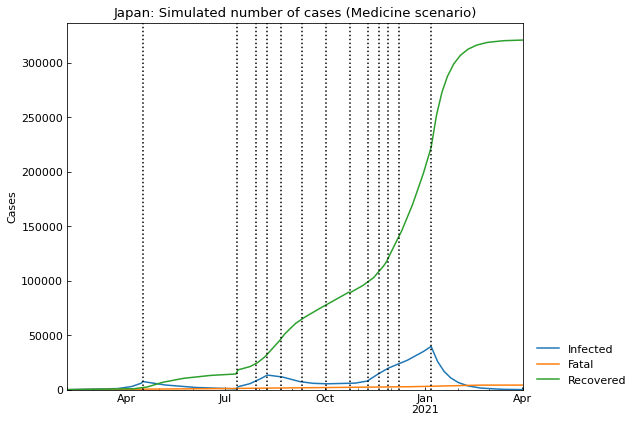

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,324921,4230,119,320572
418,2021-03-30,324933,4230,111,320592
419,2021-03-31,324944,4230,103,320611
420,2021-04-01,324955,4230,96,320629
421,2021-04-02,324966,4230,90,320646


In [20]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [21]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,13th_Rt
Main,172140,02Apr2021,1095840,172140,13348,1.2
Medicine,39686,07Jan2021,324966,90,4230,0.6


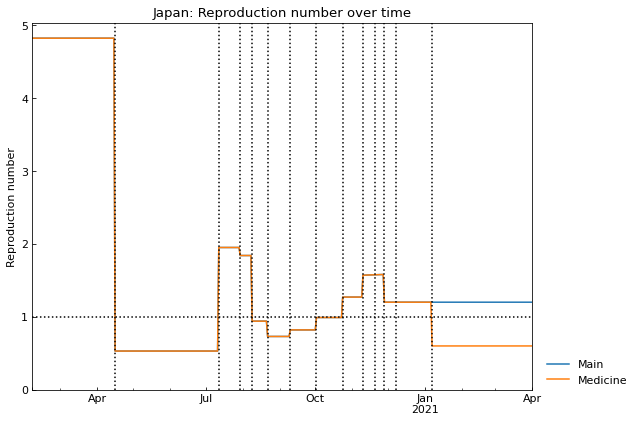

In [22]:
_ = snl.history(target="Rt")

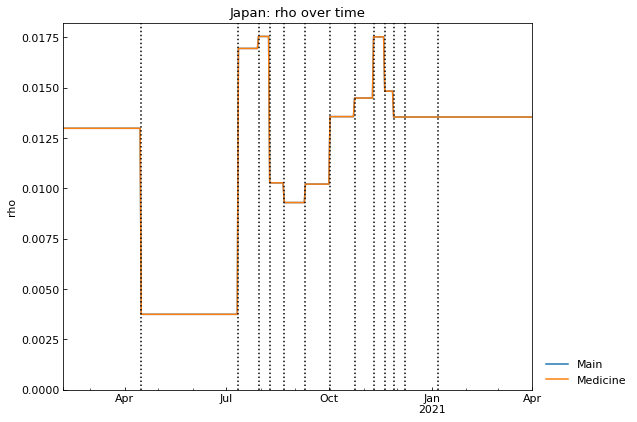

In [23]:
_ = snl.history(target="rho")

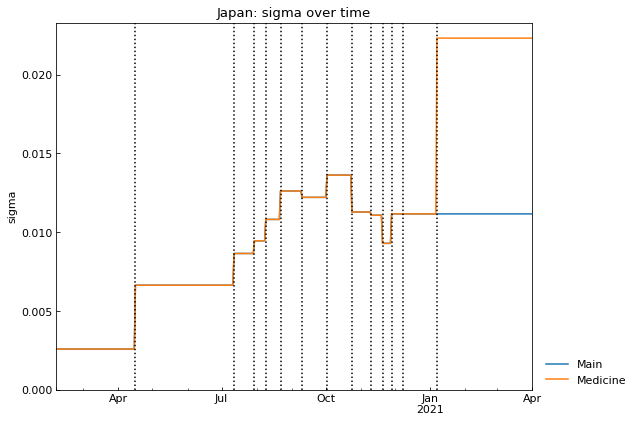

In [24]:
_ = snl.history(target="sigma")

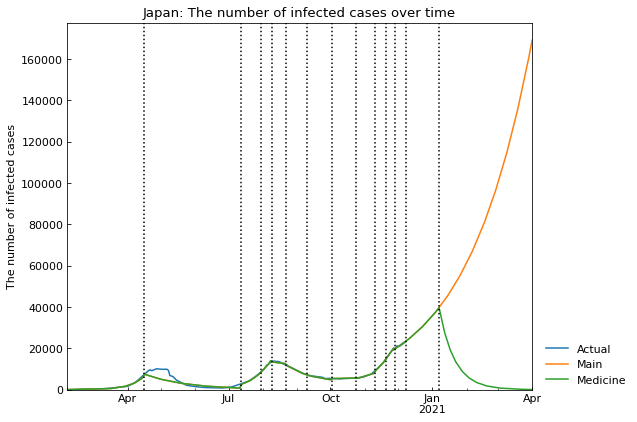

In [25]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

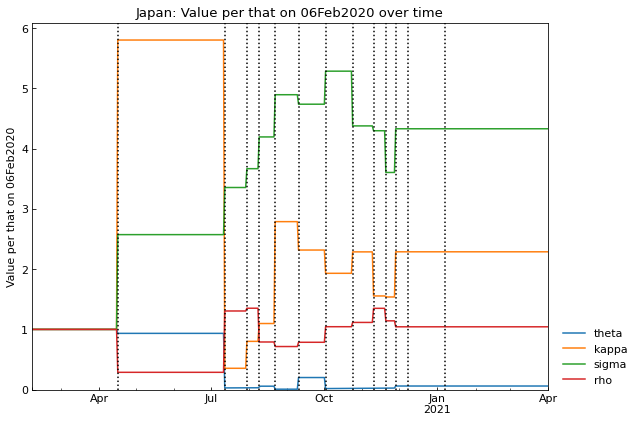

In [26]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [27]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 3rd phase (10Sep2020 - 01Oct2020): finished  251 trials in 0 min 10 sec


	 0th phase (06Feb2020 - 15Apr2020): finished 3402 trials in 3 min  0 sec

	11th phase (24Oct2020 - 09Nov2020): finished 3486 trials in 3 min  0 sec

	 6th phase (30Jul2020 - 08Aug2020): finished 3504 trials in 3 min  0 sec

	 9th phase (02Oct2020 - 23Oct2020): finished 3464 trials in 3 min  0 sec

	 2nd phase (10Nov2020 - 19Nov2020): finished  346 trials in 0 min 10 sec

	 1st phase (01Sep2020 - 09Sep2020): finished  346 trials in 0 min 10 sec

	 7th phase (22Aug2020 - 31Aug2020): finished  349 trials in 0 min 10 sec

	12th phase (28Nov2020 - 07Dec2020): finished 1200 trials in 0 min 40 sec

	10th phase (16Apr2020 - 11Jul2020): finished 3236 trials in 3 min  0 sec

	 5th phase (12Jul2020 - 29Jul2020): finished 3344 trials in 3 min  0 sec

	 4th phase (09Aug2020 - 21Aug2020): finished 3367 trials in 3 min  0 sec

	 8th phase (20Nov2020 - 27Nov2020): finished 3412 trials in 3 min  0 sec

Completed optimization. Total: 6 min 52 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 5th phase (01Sep2020 - 07Dec2020): finished 10888 trials in 3 min  0 sec

Completed optimization. Total: 3 min  0 sec


In [28]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  15Apr2020  SIR-F  4.82  0.018200  0.000063   
              1st    16Apr2020  11Jul2020  SIR-F  0.53  0.017007  0.000366   
              2nd    12Jul2020  29Jul2020  SIR-F  1.95  0.000537  0.000022   
              3rd    30Jul2020  08Aug2020  SIR-F  1.87  0.000536  0.000022   
              4th    09Aug2020  21Aug2020  SIR-F  0.94  0.001060  0.000069   
              5th    22Aug2020  31Aug2020  SIR-F  0.76  0.000514  0.000158   
              6th    01Sep2020  09Sep2020  SIR-F  0.68  0.000132  0.000168   
              7th    10Sep2020  01Oct2020  SIR-F  0.82  0.003673  0.000146   
              8th    02Oct2020  23Oct2020  SIR-F  0.99  0.000175  0.000119   
              9th    24Oct2020  09Nov2020  SIR-F  1.27  0.000086  0.000144   
              10th   10Nov2020  19Nov2020  SIR-F  1.57  0.000435  0.000098   
              11th   20Nov2020  27Nov2020  SIR-F  1.58  0.000493  0.000097   
              12th   28Nov2020  07Dec2020  SIR-F  1.20  0.001111  0.000144   
Retrospective 0th    06Feb2020  15Apr2020  SIR-F  4.82  0.018200  0.000063   
              1st    16Apr2020  11Jul2020  SIR-F  0.53  0.017007  0.000366   
              2nd    12Jul2020  29Jul2020  SIR-F  1.95  0.000537  0.000022   
              3rd    30Jul2020  08Aug2020  SIR-F  1.87  0.000536  0.000022   
              4th    09Aug2020  21Aug2020  SIR-F  0.94  0.001060  0.000069   
              5th    22Aug2020  31Aug2020  SIR-F  0.76  0.000514  0.000158   
              6th    01Sep2020  07Dec2020  SIR-F  0.76  0.000514  0.000158   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.012977  0.002578  0.255924    3402  3 min  0 sec  
              1st    0.003742  0.006631  0.336706    3236  3 min  0 sec  
              2nd    0.016942  0.008646  0.018865    3344  3 min  0 sec  
              3rd    0.017732  0.009470  0.029713    3504  3 min  0 sec  
              4th    0.010270  0.010808  0.026671    3367  3 min  0 sec  
              5th    0.009491  0.012389  0.016546     349  0 min 10 sec  
              6th    0.008307  0.011964  0.009481     346  0 min 10 sec  
              7th    0.010206  0.012208  0.038529     251  0 min 10 sec  
              8th    0.013462  0.013494  0.013895    3464  3 min  0 sec  
              9th    0.014478  0.011280  0.019875    3486  3 min  0 sec  
              10th   0.017515  0.011073  0.013255     346  0 min 10 sec  
              11th   0.014821  0.009289  0.022252    3412  3 min  0 sec  
              12th   0.013537  0.011157  0.011330    1200  0 min 40 sec  
Retrospective 0th    0.012977  0.002578  0.255924    3402  3 min  0 sec  
              1st    0.003742  0.006631  0.336706    3236  3 min  0 sec  
              2nd    0.016942  0.008646  0.018865    3344  3 min  0 sec  
              3rd    0.017732  0.009470  0.029713    3504  3 min  0 sec  
              4th    0.010270  0.010808  0.026671    3367  3 min  0 sec  
              5th    0.009491  0.012389  0.016546     349  0 min 10 sec  
              6th    0.009491  0.012389  0.878123   10888  3 min  0 sec

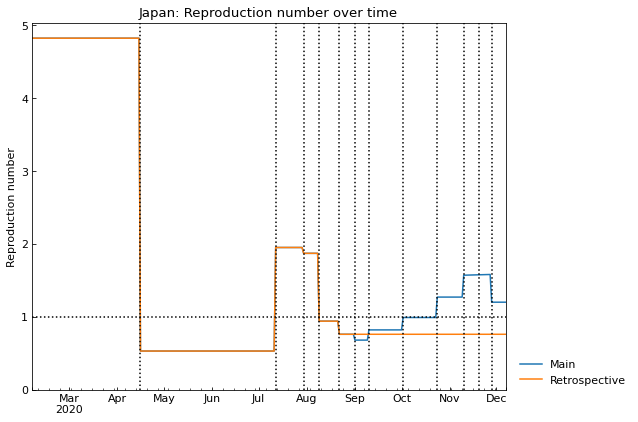

In [29]:
# History of reproduction number
_ = snl_retro.history("Rt")

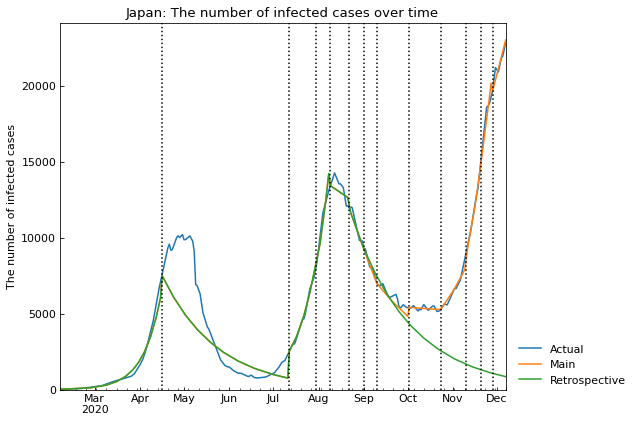

In [30]:
# History of Infected
_ = snl_retro.history("Infected")

In [31]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 08Dec2020,Infected on 08Dec2020,Fatal on 08Dec2020,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,23420,08Dec2020,165293,23420,2348,0.68,0.82,0.99,1.27,1.57,1.58,1.2
Retrospective,14221,08Aug2020,94478,840,1744,0.76,-,-,-,-,-,-
